# 郵送最適化
- 実際の物流 Data から Network 構造を可視化する方法。
- 最適な物流計画を立案する

In [1]:
import pandas as pd

# 生産工場の Data
factories = pd.read_csv('sample_code/chapter_6/tbl_factory.csv', index_col=0)
factories

,FCName,FCDemand,FCRegion
FCID,,,
FC00001,東京工場,28,関東
FC00002,木更津工場,29,関東
FC00003,多摩工場,31,関東
FC00004,横須賀工場,25,関東
FC00005,仙台工場,21,東北
FC00006,山形工場,30,東北
FC00007,那須工場,25,東北
FC00008,青森工場,16,東北


In [2]:
# 倉庫の Data
warehouses = pd.read_csv('sample_code/chapter_6/tbl_warehouse.csv', index_col=0)
warehouses

,WHName,WHSupply,WHRegion
WHID,,,
WH00001,杉並倉庫,35,関東
WH00002,品川倉庫,41,関東
WH00003,豊洲倉庫,42,関東
WH00004,郡山倉庫,60,東北
WH00005,仙台倉庫,72,東北
WH00006,山形倉庫,65,東北


In [3]:
# 倉庫と工場間の輸送 Cost
cost = pd.read_csv('sample_code/chapter_6/rel_cost.csv', index_col=0)
cost.head()

,FCID,WHID,Cost
RCostID,,,
1,FC00001,WH00001,0.4
2,FC00001,WH00002,0.8
3,FC00001,WH00003,1.5
4,FC00002,WH00001,0.9
5,FC00002,WH00002,0.8


In [4]:
# 2019年の工場への部品輸送実績
trans = pd.read_csv('sample_code/chapter_6/tbl_transaction.csv', index_col=0)
trans.head()

,TransactionDate,ToFC,FromWH,Quantity
TRID,,,,
0,2019-01-01 02:11:10,FC00004,WH00003,33
1,2019-01-01 06:12:42,FC00007,WH00006,19
2,2019-01-01 06:32:32,FC00006,WH00004,31
3,2019-01-01 07:17:06,FC00002,WH00003,18
4,2019-01-01 07:52:18,FC00001,WH00002,30


### 工場 & 倉庫 Data
- 工場 Data(factories)の「FCID」
- 倉庫 Data(warehouses)の「WHID」

は、Cost data と輸送実績(trans) data にも登場しているので Key と判断する。

### Cost data
工場 Data と倉庫 Data の組み合わせ毎の Cost が管理されている。

### 輸送実績 Data
- 実際の輸送日時(TransactionDate)
- 輸送先工場(ToFC)
- 輸送元倉庫(FromWH)
- 輸送個数(Quantity)

が Log として保持されている。

Data 分析の基礎となるべき Data は輸送実績(trans)と判断し、主体として各 Data を結合(Left join)していく。

In [5]:
# trans data を主に cost data を結合
join_data = pd.merge(trans, cost, left_on=['ToFC', 'FromWH'], right_on=['FCID', 'WHID'], how='left')
join_data.head()

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8


In [6]:
# factories data を 結合
join_data = pd.merge(join_data, factories, left_on='ToFC', right_on='FCID', how='left')
join_data.head()

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost,FCName,FCDemand,FCRegion
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1,横須賀工場,25,関東
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3,那須工場,25,東北
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9,山形工場,30,東北
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6,木更津工場,29,関東
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8,東京工場,28,関東


In [7]:
# warehouses data を結合
join_data = pd.merge(join_data, warehouses, left_on='FromWH', right_on='WHID', how='left')
join_data = join_data[['TransactionDate', 'Quantity', 'Cost', 'ToFC', 'FCName', 'FCDemand', 'FromWH', 'WHName',
                       'WHSupply', 'WHRegion']]  # 並びを変更して視認性をあげる
join_data.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,横須賀工場,25,WH00003,豊洲倉庫,42,関東
1,2019-01-01 06:12:42,19,1.3,FC00007,那須工場,25,WH00006,山形倉庫,65,東北
2,2019-01-01 06:32:32,31,0.9,FC00006,山形工場,30,WH00004,郡山倉庫,60,東北
3,2019-01-01 07:17:06,18,1.6,FC00002,木更津工場,29,WH00003,豊洲倉庫,42,関東
4,2019-01-01 07:52:18,30,0.8,FC00001,東京工場,28,WH00002,品川倉庫,41,関東


関東支社と東北支社の Data を比較する

In [8]:
kanto = join_data.loc[join_data['WHRegion'] == '関東']
kanto.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,横須賀工場,25,WH00003,豊洲倉庫,42,関東
3,2019-01-01 07:17:06,18,1.6,FC00002,木更津工場,29,WH00003,豊洲倉庫,42,関東
4,2019-01-01 07:52:18,30,0.8,FC00001,東京工場,28,WH00002,品川倉庫,41,関東
7,2019-01-01 09:09:30,12,1.5,FC00001,東京工場,28,WH00003,豊洲倉庫,42,関東
8,2019-01-01 10:52:55,27,1.5,FC00003,多摩工場,31,WH00003,豊洲倉庫,42,関東


In [9]:
tohoku = join_data.loc[join_data['WHRegion'] == '東北']
tohoku.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
1,2019-01-01 06:12:42,19,1.3,FC00007,那須工場,25,WH00006,山形倉庫,65,東北
2,2019-01-01 06:32:32,31,0.9,FC00006,山形工場,30,WH00004,郡山倉庫,60,東北
5,2019-01-01 08:56:09,31,0.3,FC00005,仙台工場,21,WH00005,仙台倉庫,72,東北
6,2019-01-01 09:00:15,33,0.7,FC00006,山形工場,30,WH00006,山形倉庫,65,東北
9,2019-01-01 14:12:51,21,0.7,FC00006,山形工場,30,WH00006,山形倉庫,65,東北


実際の輸送量や掛かっている Cost を確認し、支社間で比較していく。

In [10]:
print(f'関東支社の総コスト{str(kanto["Cost"].sum())}万円')
print(f'東北支社の総コスト{str(tohoku["Cost"].sum())}万円')

関東支社の総コスト2189.3万円
東北支社の総コスト2062.0万円


関東支社の方が東北支社よりも輸送 Cost の総額が多くかかっていることがわかる。

In [11]:
print(f'関東支社の層部品輸送個数: {str(kanto["Quantity"].sum())}個')
print(f'東北支社の層部品輸送個数: {str(tohoku["Quantity"].sum())}個')

関東支社の層部品輸送個数: 49146個
東北支社の層部品輸送個数: 50214個


関東支社より東北支社の方が多くの部品を輸送していることがわかる。

In [12]:
tmp = (kanto['Cost'].sum() / kanto['Quantity'].sum()) * 10_000
print(f'関東支社の部品１つ当たりの輸送 Cost: {str(int(tmp))}円')
tmp = (tohoku['Cost'].sum() / tohoku['Quantity'].sum()) * 10_000
print(f'東北支社の部品１つ当たりの輸送 Cost: {str(int(tmp))}円')

関東支社の部品１つ当たりの輸送 Cost: 445円
東北支社の部品１つ当たりの輸送 Cost: 410円


当然、東北支社の１つ当たりの輸送 Cost が低い。

In [13]:
cost_chk = pd.merge(cost, factories, on='FCID', how='left')
print(f'東京支社の平均輸送 Cost: {str(cost_chk["Cost"].loc[cost_chk["FCRegion"] == "関東"].mean())}万円')
print(f'東北支社の平均輸送 Cost: {str(cost_chk["Cost"].loc[cost_chk["FCRegion"]=="東北"].mean())}万円')

東京支社の平均輸送 Cost: 1.075万円
東北支社の平均輸送 Cost: 1.05万円


各支社の平均輸送 Cost はほぼ同じ。
集計の結果、東北支社の方が関東支社よりも**効率よく**部品の輸送が行えている。

---
NetworkX の基礎的な Process

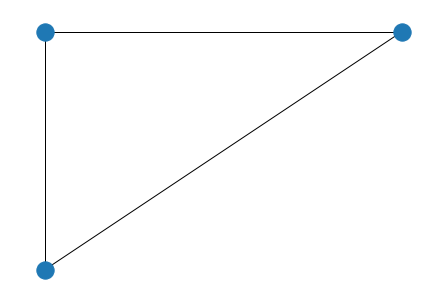

In [18]:
import networkx as nx
import matplotlib.pyplot as plt

# Class Object の作成
G = nx.Graph()

# 頂点の設定
G.add_node('nodeA')
G.add_node('nodeB')
G.add_node('nodeC')

# 辺の設定
G.add_edge('nodeA', 'nodeB')
G.add_edge('nodeA', 'nodeC')
G.add_edge('nodeB', 'nodeC')

# 座標の設定
pos ={}
pos['nodeA'] = (0, 0)
pos['nodeB'] = (1, 1)
pos['nodeC'] = (0, 1)

# 描画
nx.draw(G, pos)

# 表示
plt.show()

Network 可視化を行い
- 倉庫から小売店までの物流などを表現する。
- 数値だけではわかりにくかった物流の偏りなどの全体像を掴む。
---

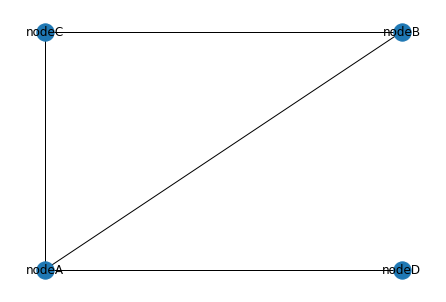

In [17]:
G.add_node('nodeD')
G.add_edge('nodeA', 'nodeD')
pos['nodeD']=(1, 0)
nx.draw(G, pos, with_labels=True)
plt.show()